## 0. Import Libraries

In [1]:
# ====================================================================
# STEP 0: Import Libraries
# ====================================================================
# 과제에 사용할 library들을 import

# 시스템 및 입출력 관련
import os  # 디렉토리, 파일 경로 조작 등
from PIL import Image  # 이미지 열기 및 처리 (Pillow)
from tqdm import tqdm  # 반복문의 진행 상태 시각화
from pathlib import Path  # payhon path
import json


# 시각화 도구
import matplotlib.pyplot as plt  # 기본 시각화 라이브러리
import seaborn as sns  # 고급 시각화 (히트맵, 스타일 등)

# 이미지 처리
import cv2  # OpenCV - 고급 이미지/비디오 처리

# 수치 연산
import numpy as np  # 배열, 벡터 계산 등

# PyTorch 기본 구성
import torch  # 텐서, 연산 등
import torch.nn as nn  # 모델 정의 (layer, loss 등)
import torch.nn.functional as F
import torch.optim as optim  # Optimizer (SGD, Adam 등)

# PyTorch 데이터 처리
from torch.utils.data import Dataset, DataLoader  # 커스텀 데이터셋, 배치 로딩

# PyTorch 이미지 전처리
import torchvision
from torchvision import transforms  # 기본 이미지 transform
from torchvision import datasets  # torchvision 내장 데이터셋
import torchvision.models as models

from torchvision.transforms import v2  # torchvision v2 transforms (최신 API)

# 싸이킷런 평가 지표
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# 싸이킷런 데이터 나누기
from sklearn.model_selection import train_test_split

# 통계 tool
import pandas as pd

# 실험 추적 및 하이퍼파라미터 관리
import wandb  # Weights & Biases - 실험 로깅, 시각화, 하이퍼파라미터 튜닝

# Garbage Collector 모듈
import gc

# Data Augmentation 패키지: Albumentations
import albumentations as A

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## 1. Set configuration

In [2]:
# ====================================================================
# STEP 1: Configuration 설정
# ====================================================================
# 하이퍼파라미터 및 경로 등 실험에 필요한 설정들을 모아둠
# 실험 추적 및 재현성을 위해 모든 값은 여기에서 수정하고자 함

# 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 주요 하이퍼파라미터
LEARNING_RATE = 1e-4  # 학습률 (optimizer용)
BATCH_SIZE = 16  # 배치 크기
NUM_EPOCHS = 100  # 학습 epoch 수
SEED = 42  # 재현성을 위한 random seed

# 데이터 경로 설정
# DATA_ROOT = path
# train_dir = os.path.join(DATA_ROOT, "train")
# val_dir = os.path.join(DATA_ROOT, "val")
# test_dir = os.path.join(DATA_ROOT, "test")

# 모델 설정
MODEL_NAME = "PROJECT1_baseline"  # 또는 "EfficientNet", 등등
USE_PRETRAINED = True  # torchvision 모델 사용 여부

# 학습 고도화 설정 (Optional)
USE_SCHEDULER = True  # Learning rate scheduler 사용 여부
EARLY_STOPPING = True  # Early stopping 적용 여부
AUGMENTATION = True  # 데이터 증강 사용 여부

# 실험 로깅용 설정
USE_WANDB = True
WANDB_PROJECT = "cats-and-dogs-breeds-classification-oxford-dataset"
RUN_NAME = f"{MODEL_NAME}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"

Using device: cuda


## 2. Data pre-processing

In [3]:
# ====================================================================\n",
# STEP 2: Data Pre-processing\n",
# ====================================================================\n",

# 데이터셋 경로 (수정 필요)
DATA_ROOT = "../data/raw/ai03-level1-project/"  # 경로
train_image_dir = os.path.join(DATA_ROOT, "train_images")
train_ann_dir = os.path.join(DATA_ROOT, "train_annotations")
test_image_dir = os.path.join(DATA_ROOT, "test_images")
train_image_dir

'../data/raw/ai03-level1-project/train_images'

In [4]:
# --- 경로 및 파일 존재 여부 확인 ---

# 1. 어노테이션 디렉토리 경로가 실제로 존재하는지 확인
print(f"어노테이션 디렉토리 경로: {train_ann_dir}")
print(f"경로가 존재하나요? -> {os.path.exists(train_ann_dir)}")

# 2. 해당 디렉토리 안에 파일이 뭐가 있는지 확인 (상위 5개만)
if os.path.exists(train_ann_dir):
    file_list = os.listdir(train_ann_dir)
    print(f"디렉토리 내 파일 목록 (상위 5개): {file_list[:5]}")

    # 3. 그 중에서 .json으로 끝나는 파일이 몇 개나 있는지 확인
    json_file_list = [f for f in file_list if f.endswith(".json")]
    print(f"찾은 JSON 파일 개수: {len(json_file_list)}개")
else:
    print(
        "경로를 찾을 수 없어요. DATA_ROOT나 train_ann_dir 경로 설정을 다시 확인해주세요!"
    )

어노테이션 디렉토리 경로: ../data/raw/ai03-level1-project/train_annotations
경로가 존재하나요? -> True
디렉토리 내 파일 목록 (상위 5개): ['K-003544-010221-016551-021026_json', 'K-003483-027733-028763-029667_json', 'K-003483-020238-027733-031885_json', 'K-002483-012081-023223-025438_json', 'K-003483-016232-022347-025469_json']
찾은 JSON 파일 개수: 0개


In [ ]:
# --- 폴더 내부 확인 ---

# 경고가 발생한 폴더 중 하나를 샘플로 지정
sample_folder_name = "K-003544-010221-016551-021026_json"
sample_folder_path = os.path.join(train_ann_dir, sample_folder_name)

print(f"'{sample_folder_path}' 폴더 내부를 확인합니다.")

# 폴더가 실제로 존재하는지 다시 한번 확인하고,
if os.path.exists(sample_folder_path) and os.path.isdir(sample_folder_path):
    # 폴더 안의 파일/폴더 목록을 보여줘!
    contents = os.listdir(sample_folder_path)
    print(f"폴더 내용물: {contents}")
else:
    print("샘플 폴더를 찾을 수 없어요. 이전 단계의 폴더 목록을 다시 확인해주세요.")

'../data/raw/ai03-level1-project/train_annotations/K-003544-010221-016551-021026_json' 폴더 내부를 확인합니다.
폴더 내용물: ['K-010221', 'K-003544', 'K-021026', 'K-016551']


In [6]:
# --- 하나의 경로에 대한 정밀 분석 ---

# 1. 이미지 어노테이션 폴더 경로
image_dir_path = os.path.join(train_ann_dir, "K-003544-010221-016551-021026_json")

# 2. 그 안에 있던 항목 중 하나
item_name = "K-010221"

# 3. 분석할 대상의 전체 경로
full_item_path = os.path.join(image_dir_path, item_name)

print(f"--- 최종 점검 ---")
print(f"점검 대상: {full_item_path}")

# 경로가 실제로 존재하는지 확인
exists = os.path.exists(full_item_path)
print(f"1. 이 경로가 존재하나요? -> {exists}")

if exists:
    # 파일인지 확인
    is_file = os.path.isfile(full_item_path)
    print(f"2. '파일' 인가요? -> {is_file}")

    # 폴더인지 확인
    is_dir = os.path.isdir(full_item_path)
    print(f"3. '폴더' 인가요? -> {is_dir}")

    # 만약 폴더라면, 그 안의 내용물까지 확인해보자
    if is_dir:
        print(f"\n이것도 폴더였네요! '{item_name}' 폴더 안을 확인합니다...")
        print(f"-> 내용물: {os.listdir(full_item_path)}")
    # 만약 파일이라면, 내용을 한번 읽어보자
    elif is_file:
        print(f"\n파일이 맞습니다! 내용을 확인합니다...")
        try:
            with open(full_item_path, "r") as f:
                print(f.read())
        except Exception as e:
            print(f"파일을 읽는데 실패했습니다: {e}")

--- 최종 점검 ---
점검 대상: ../data/raw/ai03-level1-project/train_annotations/K-003544-010221-016551-021026_json/K-010221
1. 이 경로가 존재하나요? -> True
2. '파일' 인가요? -> False
3. '폴더' 인가요? -> True

이것도 폴더였네요! 'K-010221' 폴더 안을 확인합니다...
-> 내용물: ['K-003544-010221-016551-021026_0_2_0_2_75_000_200.json', 'K-003544-010221-016551-021026_0_2_0_2_90_000_200.json', 'K-003544-010221-016551-021026_0_2_0_2_70_000_200.json']


In [ ]:
import pandas as pd
import os
import json
from tqdm import tqdm


print(f"어노테이션 디렉토리 경로: {train_ann_dir}")

# Level 1: 이미지별 폴더 목록
image_level_dirs = os.listdir(train_ann_dir)
print(f"총 {len(image_level_dirs)}개의 이미지를 처리합니다.")

all_annotations = []

# Level 1 순회 (이미지 폴더)
for image_dir_name in tqdm(image_level_dirs, desc="[L1] Images"):
    image_dir_path = os.path.join(train_ann_dir, image_dir_name)
    if not os.path.isdir(image_dir_path):
        continue

    # Level 2: 이미지 폴더 안의 알약 종류 폴더 목록
    pill_level_dirs = os.listdir(image_dir_path)

    # Level 2 순회 (알약 종류 폴더)
    for pill_dir_name in pill_level_dirs:
        pill_dir_path = os.path.join(image_dir_path, pill_dir_name)
        if not os.path.isdir(pill_dir_path):
            continue

        # Level 3: 실제 .json 파일 목록
        json_files = [f for f in os.listdir(pill_dir_path) if f.endswith(".json")]

        # .json 파일이 있다면, 그 중 첫 번째 파일만 사용
        if json_files:
            json_file_path = os.path.join(pill_dir_path, json_files[0])

            try:
                # 한글 깨짐 방지를 위해 encoding='utf-8' 추가
                with open(json_file_path, "r", encoding="utf-8") as f:
                    ann_data = json.load(f)

                    image_info = ann_data.get("images", [{}])[0]
                    annotation_info = ann_data.get("annotations", [{}])[0]
                    category_info = ann_data.get("categories", [{}])[0]

                    all_annotations.append(
                        {
                            "image_id": image_info.get("id"),
                            "file_name": image_info.get("file_name"),
                            "category_id": category_info.get("id"),
                            "class_name": category_info.get("name"),
                            "bbox": annotation_info.get("bbox"),
                        }
                    )
            except Exception as e:
                print(f"\n파일 처리 에러: {json_file_path}, 에러: {e}")

# 전처리된 DataFrame을 csv 파일로 저장
save_path = "../data/processed/train_df.csv"
os.makedirs(os.path.dirname(save_path), exist_ok=True) # 폴더가 없으면 만들어줌
df.to_csv(save_path, index=False)


# 최종 DataFrame 생성
train_df = pd.DataFrame(all_annotations)
print("\n\n--- 데이터 로드 최종 완료! ---")

test_df = pd.DataFrame({"file_name": os.listdir(test_image_dir)})


# 이제 df.head()를 확인해보자!
train_df.head()

어노테이션 디렉토리 경로: ../data/raw/ai03-level1-project/train_annotations
총 498개의 이미지를 처리합니다.


[L1] Images: 100%|██████████| 498/498 [00:00<00:00, 3256.41it/s]



--- 데이터 로드 최종 완료! ---


,image_id,file_name,category_id,class_name,bbox
0,895,K-003544-010221-016551-021026_0_2_0_2_75_000_2...,10220,쎄로켈정 100mg,"[584, 774, 227, 223]"
1,896,K-003544-010221-016551-021026_0_2_0_2_90_000_2...,3543,무코스타정(레바미피드)(비매품),"[110, 234, 207, 200]"
2,895,K-003544-010221-016551-021026_0_2_0_2_75_000_2...,21025,펠루비정(펠루비프로펜),"[101, 821, 178, 180]"
3,895,K-003544-010221-016551-021026_0_2_0_2_75_000_2...,16550,동아가바펜틴정 800mg,"[534, 42, 296, 458]"
4,1310,K-003483-027733-028763-029667_0_2_0_2_90_000_2...,28762,트라젠타정(리나글립틴),"[194, 195, 212, 202]"


In [9]:
# DataFrame의 전체적인 정보 출력
print("--- DataFrame Info ---")
train_df.info()

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876 entries, 0 to 1875
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_id     1876 non-null   int64 
 1   file_name    1876 non-null   object
 2   category_id  1876 non-null   int64 
 3   class_name   1876 non-null   object
 4   bbox         1876 non-null   object
dtypes: int64(2), object(3)
memory usage: 73.4+ KB


In [10]:
# 1. 클래스(알약 이름)별 개수 세기
class_counts = train_df["class_name"].value_counts()
print("--- 클래스별 알약 개수 (상위 10개) ---")
class_counts.head(20)

--- 클래스별 알약 개수 (상위 10개) ---


class_name
기넥신에프정(은행엽엑스)(수출용)       206
일양하이트린정 2mg               98
뮤테란캡슐 100mg               74
보령부스파정 5mg                74
동아가바펜틴정 800mg             58
가바토파정 100mg               58
리바로정 4mg                  46
아토젯정 10/40mg              46
리피토정 20mg                 45
크레스토정 20mg                45
로수젯정10/5밀리그램              44
무코스타정(레바미피드)(비매품)         41
플라빅스정 75mg                40
트윈스타정 40/5mg              36
카나브정 60mg                 35
트라젠타정(리나글립틴)              35
자누메트엑스알서방정 100/1000mg     35
세비카정 10/40mg              35
아모잘탄정 5/100mg             34
자누메트정 50/850mg            34
Name: count, dtype: int64

--- 이미지 당 알약 개수 통계 ---
count    804.000000
mean       2.333333
std        1.127416
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
dtype: float64


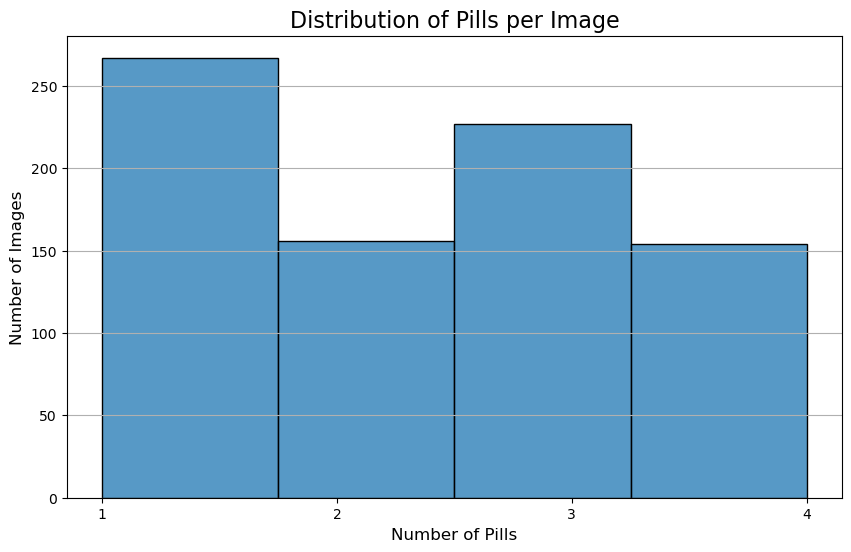

In [11]:
# 이미지 ID(file_name)로 그룹화하여 각 이미지에 몇 개의 알약이 있는지 계산
pills_per_image = train_df.groupby("file_name").size()

print("--- 이미지 당 알약 개수 통계 ---")
print(pills_per_image.describe())

# 히스토그램으로 시각화
plt.figure(figsize=(10, 6))
sns.histplot(pills_per_image, bins=pills_per_image.max(), kde=False)
plt.title("Distribution of Pills per Image", fontsize=16)
plt.xlabel("Number of Pills", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(range(1, pills_per_image.max() + 1))
plt.grid(axis="y")
plt.show()

In [12]:
# 사용자 정의 데이터셋 클래스
class PillDataset(Dataset):
    # --- 변경점 1: mode 파라미터 추가 및 df를 직접 받도록 수정 ---
    def __init__(self, df, image_dir, mode="train", transforms=None):
        self.df = df
        self.image_dir = Path(image_dir)
        self.mode = mode
        self.transforms = transforms

        # --- 변경점 2: image_ids를 미리 뽑아 중복을 제거 ---
        # df['file_name']을 사용하면 이미지 파일 이름으로 고유한 이미지를 식별할 수 있어.
        self.image_ids = self.df["file_name"].unique()

    def __len__(self):
        # --- 변경점 3: 고유한 이미지의 개수를 반환 ---
        return len(self.image_ids)

    def __getitem__(self, idx):
        # 고유 이미지 ID(파일 이름)를 가져옴
        image_id = self.image_ids[idx]
        image_path = self.image_dir / image_id

        # 이미지 로드
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # --- 변경점 4: mode에 따라 다르게 동작 ---
        # 학습 모드일 경우, 어노테이션(target)까지 준비
        if self.mode == "train":
            # 현재 이미지에 해당하는 모든 어노테이션(알약)을 df에서 필터링
            records = self.df[self.df["file_name"] == image_id]

            boxes = records[["bbox_x", "bbox_y", "bbox_w", "bbox_h"]].values
            # bbox: [x, y, w, h] -> [xmin, ymin, xmax, ymax]
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

            labels = records["category_id"].values

            target = {
                "boxes": torch.as_tensor(boxes, dtype=torch.float32),
                "labels": torch.as_tensor(labels, dtype=torch.int64),
            }

            # Augmentation 적용
            if self.transforms:
                transformed = self.transforms(
                    image=image, bboxes=target["boxes"], labels=target["labels"]
                )
                image = transformed["image"]
                target["boxes"] = torch.as_tensor(
                    transformed["bboxes"], dtype=torch.float32
                )
                if len(target["boxes"]) == 0:
                    target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)

            return image, target

        # 테스트 모드일 경우, 이미지와 파일 이름만 반환
        elif self.mode == "test":
            # 테스트 시에는 보통 기본적인 리사이즈, 정규화만 적용
            if self.transforms:
                transformed = self.transforms(image=image)
                image = transformed["image"]

            # 나중에 예측 결과를 이미지와 매칭시키기 위해 파일 이름을 반환
            return image, image_id

In [14]:
# 데이터 증강 (Augmentation) 정의
# Albumentations를 사용하는 것이 바운딩 박스 변환에 더 유리해
train_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # PyTorch 텐서로 변환
        A.pytorch.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
)  # bbox 형식은 pascal_voc: [xmin, ymin, xmax, ymax]

test_transforms = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
)


# 데이터셋 인스턴스 생성
train_dataset = PillDataset(
    df=train_df, image_dir=train_image_dir, mode="train", transforms=train_transforms
)
test_dataset = PillDataset(
    df=test_df, image_dir=test_image_dir, mode="test", transforms=test_transforms
)  # Augmentation은 보통 검증용과 동일하게 적용


# DataLoader를 위한 collate_fn. 이미지와 타겟을 리스트로 묶어줌
def collate_fn(batch):
    return tuple(zip(*batch))


# 데이터 로더 생성 (실제 데이터셋 경로 설정 후 주석 해제)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

print("DataLoaders are ready.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(test_loader)}")

DataLoaders are ready.
Number of training samples: 804
Number of validation samples: 53


## 3. Model implementation

## 4. Train and Evaluate models

## 5. Train and Evaluate a model

## 6. Results & Disscussion

## 7. Conclusion